In [2]:
import pandas as pd
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from sharadar.pipeline.factors import (
    MarketCap,
    EV,
    Fundamentals
)
from sharadar.pipeline.engine import load_sharadar_bundle, symbol, symbols, make_pipeline_engine
from zipline.pipeline.filters import StaticAssets
import time
import datetime

In [3]:
spe = make_pipeline_engine()

In [4]:
bundle = load_sharadar_bundle()

In [5]:
bundle.equity_daily_bar_reader.first_trading_day

Timestamp('1997-12-31 00:00:00+0000', tz='UTC')

In [6]:
bundle.equity_daily_bar_reader.last_available_dt

Timestamp('2021-03-11 00:00:00+0000', tz='UTC')

In [7]:
pipe_start = pd.to_datetime('2021-01-04', utc=True)
pipe_end = bundle.equity_daily_bar_reader.last_available_dt
macro = symbols(['TR3M', 'TR6M', 'TR1Y', 'TR2Y', 'TR3Y', 'TR5Y', 'TR7Y', 'TR10Y','TR20Y','CBOND', 'INDPRO', 'INDPROPCT', 'PMICMP', 'UNRATE', 'RATEINF'])
pipe = Pipeline(columns={
    'Close': USEquityPricing.close.latest,
},
screen = StaticAssets(macro)
)
stocks = spe.run_pipeline(pipe, pipe_start, pipe_end)
stocks.tail(30)

[2021-03-12 17:59:22] INFO: Percent completed:   0% (2021-01-04 - 2021-03-11): None
[2021-03-12 17:59:22] INFO: Percent completed:   0% (2021-01-04 - 2021-03-11): [EquityPricing<US>.close::float64]
[2021-03-12 17:59:25] INFO: Percent completed:  33% (2021-01-04 - 2021-03-11): [EquityPricing<US>.close::float64]
[2021-03-12 17:59:25] INFO: Percent completed:  33% (2021-01-04 - 2021-03-11): [Latest([EquityPricing<US>.close], 1)]
[2021-03-12 17:59:25] INFO: Percent completed:  67% (2021-01-04 - 2021-03-11): [Latest([EquityPricing<US>.close], 1)]
[2021-03-12 17:59:25] INFO: Percent completed:  67% (2021-01-04 - 2021-03-11): [StaticAssets([], 0)]
[2021-03-12 17:59:25] INFO: Percent completed: 100% (2021-01-04 - 2021-03-11): [StaticAssets([], 0)]
[2021-03-12 17:59:25] INFO: Percent completed: 100% (2021-01-04 - 2021-03-11): [StaticAssets([], 0)]
[2021-03-12 17:59:27] INFO: Percent completed: 100% (2021-01-04 - 2021-03-11): [StaticAssets([], 0)]


Close
2021-03-10 00:00:00+00:00 Equity(10003 [TR3M])         0.050000
                          Equity(10006 [TR6M])         0.070000
                          Equity(10012 [TR1Y])         0.100000
                          Equity(10024 [TR2Y])         0.170000
                          Equity(10036 [TR3Y])         0.350000
                          Equity(10060 [TR5Y])         0.830000
                          Equity(10084 [TR7Y])         1.230000
                          Equity(10120 [TR10Y])        1.550000
                          Equity(10240 [TR20Y])        2.160000
                          Equity(10400 [CBOND])        2.250000
                          Equity(10410 [INDPRO])     107.184300
                          Equity(10420 [INDPROPCT])    0.009286
                          Equity(10430 [PMICMP])      60.800000
                          Equity(10440 [UNRATE])       6.200000
                          Equity(10450 [RATEINF])      1.400000
2021-03-11 00:00:00+00:00 Equity(10003 [TR3M])         0.040000
                          Equity(10006 [TR6M])         0.060000
                          Equity(10012 [TR1Y])         0.080000
                          Equity(10024 [TR2Y])         0.160000
                          Equity(10036 [TR3Y])         0.320000
                          Equity(10060 [TR5Y])         0.800000
                          Equity(10084 [TR7Y])         1.200000
                          Equity(10120 [TR10Y])        1.530000
                          Equity(10240 [TR20Y])        2.150000
                          Equity(10400 [CBOND])        2.230000
                          Equity(10410 [INDPRO])     107.184300
                          Equity(10420 [INDPROPCT])         NaN
                          Equity(10430 [PMICMP])      60.800000
                          Equity(10440 [UNRATE])       6.200000
                          Equity(10450 [RATEINF])      1.400000

In [8]:
macro

[Equity(10003 [TR3M]),
 Equity(10006 [TR6M]),
 Equity(10012 [TR1Y]),
 Equity(10024 [TR2Y]),
 Equity(10036 [TR3Y]),
 Equity(10060 [TR5Y]),
 Equity(10084 [TR7Y]),
 Equity(10120 [TR10Y]),
 Equity(10240 [TR20Y]),
 Equity(10400 [CBOND]),
 Equity(10410 [INDPRO]),
 Equity(10420 [INDPROPCT]),
 Equity(10430 [PMICMP]),
 Equity(10440 [UNRATE]),
 Equity(10450 [RATEINF])]

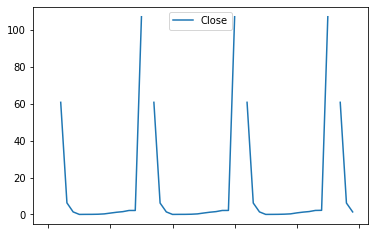

In [20]:
stocks.tail(50).plot()

In [2]:
symbol('^VIX')

Equity(111630 [^VIX])

In [11]:
symbol('SPY').to_dict()

{'sid': 118691,
 'symbol': 'SPY',
 'asset_name': 'Spdr S&P 500 Etf Trust',
 'start_date': Timestamp('1993-01-29 00:00:00+0000', tz='UTC'),
 'end_date': Timestamp('2021-02-01 00:00:00+0000', tz='UTC'),
 'first_traded': Timestamp('1993-01-29 00:00:00+0000', tz='UTC'),
 'auto_close_date': Timestamp('2021-02-02 00:00:00+0000', tz='UTC'),
 'exchange': 'NYSEARCA',
 'exchange_full': 'NYSEARCA',
 'tick_size': 0.01,
 'multiplier': 1.0,
 'exchange_info': ExchangeInfo('NYSEARCA', 'NYSEARCA', 'US')}

In [12]:
symbol('SPDN').to_dict()

{'sid': 117540,
 'symbol': 'SPDN',
 'asset_name': 'Direxion Daily S&P 500 (R) Bear 1X Shares',
 'start_date': Timestamp('2016-06-08 00:00:00+0000', tz='UTC'),
 'end_date': Timestamp('2021-02-01 00:00:00+0000', tz='UTC'),
 'first_traded': Timestamp('2016-06-08 00:00:00+0000', tz='UTC'),
 'auto_close_date': Timestamp('2021-02-02 00:00:00+0000', tz='UTC'),
 'exchange': 'NYSEARCA',
 'exchange_full': 'NYSEARCA',
 'tick_size': 0.01,
 'multiplier': 1.0,
 'exchange_info': ExchangeInfo('NYSEARCA', 'NYSEARCA', 'US')}

In [13]:
ts=pd.to_datetime('2020-02-03', utc=True)
ts

Timestamp('2020-02-03 00:00:00+0000', tz='UTC')

In [15]:
d = {symbol('SPDN'):ts, symbol('IBM'):ts, symbol('AAPL'):ts}
d

{Equity(117540 [SPDN]): Timestamp('2020-02-03 00:00:00+0000', tz='UTC'),
 Equity(199623 [IBM]): Timestamp('2020-02-03 00:00:00+0000', tz='UTC'),
 Equity(199059 [AAPL]): Timestamp('2020-02-03 00:00:00+0000', tz='UTC')}

In [21]:
from pandas.tseries.offsets import MonthEnd
ts+MonthEnd(2)

Timestamp('2020-03-31 00:00:00+0000', tz='UTC')

In [58]:
ts+MonthEnd(0)

Timestamp('2020-02-29 00:00:00+0000', tz='UTC')

In [23]:
s = pd.Series()
s.loc[symbol('SPDN')]=pd.to_datetime('2020-02-14', utc=True)+MonthEnd(2)
s.loc[symbol('IBM')]=pd.to_datetime('2020-01-03', utc=True)+MonthEnd(2)
s.loc[symbol('APL')]=pd.to_datetime('2020-03-03', utc=True)+MonthEnd(2)
s

Equity(117540 [SPDN])   2020-03-31
Equity(199623 [IBM])    2020-02-29
Equity(196267 [APL])    2020-04-30
dtype: datetime64[ns]

In [67]:
class Blacklist:
    def __init__(self, expires_in_months=2):
        self.n = expires_in_months
        self.s = pd.Series()
    
    def add_symbols(self, symbols, date):
        for symbol in symbols:
            self.s.loc[symbol] = date + MonthEnd(self.n+1)
            
    def get_symbols(self, date=None):
        if date is not None:
            self.s = self.s.loc[self.s>date]
            
        print(self.s)
        return self.s.index
    
blacklist = Blacklist(2)
blacklist.add_symbols(symbols(['IBM', 'F', 'AAPL']), pd.to_datetime('2020-02-03'))
blacklist.add_symbols(symbols(['ORCL', 'MSFT']), pd.to_datetime('2020-03-10'))

assert len(blacklist.get_symbols(pd.to_datetime('2020-03-10'))) == 5, "len should be 5"
assert len(blacklist.get_symbols(pd.to_datetime('2020-04-10'))) == 5, "len should be 5"
assert len(blacklist.get_symbols(pd.to_datetime('2020-05-10'))) == 2, "len should be 2"
assert len(blacklist.get_symbols(pd.to_datetime('2020-06-10'))) == 0, "len should be 0"

Equity(199623 [IBM])    2020-04-30
Equity(199713 [F])      2020-04-30
Equity(199059 [AAPL])   2020-04-30
Equity(194684 [ORCL])   2020-05-31
Equity(198508 [MSFT])   2020-05-31
dtype: datetime64[ns]
Equity(199623 [IBM])    2020-04-30
Equity(199713 [F])      2020-04-30
Equity(199059 [AAPL])   2020-04-30
Equity(194684 [ORCL])   2020-05-31
Equity(198508 [MSFT])   2020-05-31
dtype: datetime64[ns]
Equity(194684 [ORCL])   2020-05-31
Equity(198508 [MSFT])   2020-05-31
dtype: datetime64[ns]
Series([], dtype: datetime64[ns])


In [68]:
pd.to_datetime('2020-04-30')+MonthEnd(0)

Timestamp('2020-04-30 00:00:00')

In [40]:
blacklist.get_symbols(pd.to_datetime('2020-05-10'))

Index([], dtype='object')

In [30]:
s.loc[s>pd.to_datetime('2020-03-15', utc=True)]

Equity(117540 [SPDN])   2020-03-31
Equity(196267 [APL])    2020-04-30
dtype: datetime64[ns]

In [31]:
s.loc[s>'2020-03-15']

Equity(117540 [SPDN])   2020-03-31
Equity(196267 [APL])    2020-04-30
dtype: datetime64[ns]

In [7]:
pipe_start = pd.to_datetime('2020-02-03', utc=True)
pipe_end = pd.to_datetime('2020-02-07', utc=True)


pipe = Pipeline(columns={
    'Close': USEquityPricing.close.latest,
},
screen = StaticAssets(symbols(['IBM', 'F', 'AAPL']))
)

stocks = spe.run_pipeline(pipe, pipe_start, pipe_end)
stocks

[2021-03-10 14:59:03] INFO: Percent completed:   0% (2020-02-03 - 2020-02-07): None
[2021-03-10 14:59:03] INFO: Percent completed:   0% (2020-02-03 - 2020-02-07): [EquityPricing<US>.close::float64]
[2021-03-10 14:59:03] INFO: Percent completed:  33% (2020-02-03 - 2020-02-07): [EquityPricing<US>.close::float64]
[2021-03-10 14:59:03] INFO: Percent completed:  33% (2020-02-03 - 2020-02-07): [StaticAssets([], 0)]
[2021-03-10 14:59:03] INFO: Percent completed:  67% (2020-02-03 - 2020-02-07): [StaticAssets([], 0)]
[2021-03-10 14:59:03] INFO: Percent completed:  67% (2020-02-03 - 2020-02-07): [Latest([EquityPricing<US>.close], 1)]
[2021-03-10 14:59:03] INFO: Percent completed: 100% (2020-02-03 - 2020-02-07): [Latest([EquityPricing<US>.close], 1)]
[2021-03-10 14:59:03] INFO: Percent completed: 100% (2020-02-03 - 2020-02-07): [Latest([EquityPricing<US>.close], 1)]
[2021-03-10 14:59:05] INFO: Percent completed: 100% (2020-02-03 - 2020-02-07): [Latest([EquityPricing<US>.close], 1)]


Close
2020-02-03 00:00:00+00:00 Equity(199059 [AAPL])  309.51
                          Equity(199623 [IBM])   143.73
                          Equity(199713 [F])       8.82
2020-02-04 00:00:00+00:00 Equity(199059 [AAPL])  308.66
                          Equity(199623 [IBM])   146.27
                          Equity(199713 [F])       8.98
2020-02-05 00:00:00+00:00 Equity(199059 [AAPL])  318.85
                          Equity(199623 [IBM])   149.11
                          Equity(199713 [F])       9.18
2020-02-06 00:00:00+00:00 Equity(199059 [AAPL])  321.45
                          Equity(199623 [IBM])   156.33
                          Equity(199713 [F])       8.31
2020-02-07 00:00:00+00:00 Equity(199059 [AAPL])  324.44
                          Equity(199623 [IBM])   153.52
                          Equity(199713 [F])       8.25

In [3]:
%%time
pipe_mkt_cap = Pipeline(columns={
    'mkt_cap': MarketCap()
},
)

start_time = time.time()
stocks = spe.run_pipeline(pipe_mkt_cap, pipe_start, pipe_end)
stocks.shape

[2020-07-03 20:55:18.348540] INFO: sharadar_db_bundle: Compute pipeline values in chunks of 120 days.
[2020-07-03 20:55:18.350274] INFO: sharadar_db_bundle: Compute values for pipeline from 2020-02-03 to 2020-02-07.
[2020-07-03 20:55:18.356553] INFO: sharadar_db_bundle: Computing term 1 of 5 [AssetExists()]
[2020-07-03 20:55:18.357422] INFO: sharadar_db_bundle: Term already in workspace: no computation needed
[2020-07-03 20:55:18.358058] INFO: sharadar_db_bundle: Computing term 2 of 5 [Fundamentals{'field': 'sharesbas_arq'}]
[2020-07-03 20:55:20.697451] INFO: sharadar_db_bundle: Elapsed time: 0:00:02.339389
[2020-07-03 20:55:20.698366] INFO: sharadar_db_bundle: Computing term 3 of 5 [Fundamentals{'field': 'sharefactor_arq'}]
[2020-07-03 20:55:21.922237] INFO: sharadar_db_bundle: Elapsed time: 0:00:01.223812
[2020-07-03 20:55:21.923614] INFO: sharadar_db_bundle: Computing term 4 of 5 [USEquityPricing.close::float64]
[2020-07-03 20:55:21.930245] INFO: sharadar_db_bundle: Elapsed time: 0:

(48891, 1)

In [4]:
%%time
pipe_mkt_cap_ev = Pipeline(columns={
    'mkt_cap': MarketCap(),
    'ev': EV(),
    'debt': Fundamentals(field='debtusd_arq'),
    'cash': Fundamentals(field='cashnequsd_arq')
},
screen = StaticAssets(symbols(['IBM', 'F', 'AAPL']))
)

stocks = spe.run_pipeline(pipe_mkt_cap_ev, pipe_start, pipe_end)
stocks

[2020-07-03 20:55:28.480497] INFO: sharadar_db_bundle: Compute pipeline values in chunks of 120 days.
[2020-07-03 20:55:28.482117] INFO: sharadar_db_bundle: Compute values for pipeline from 2020-02-03 to 2020-02-07.
[2020-07-03 20:55:28.489209] INFO: sharadar_db_bundle: Computing term 1 of 9 [AssetExists()]
[2020-07-03 20:55:28.490335] INFO: sharadar_db_bundle: Term already in workspace: no computation needed
[2020-07-03 20:55:28.491284] INFO: sharadar_db_bundle: Computing term 2 of 9 [Fundamentals{'field': 'sharesbas_arq'}]
[2020-07-03 20:55:28.496066] INFO: sharadar_db_bundle: Elapsed time: 0:00:00.004796
[2020-07-03 20:55:28.496953] INFO: sharadar_db_bundle: Computing term 3 of 9 [Fundamentals{'field': 'sharefactor_arq'}]
[2020-07-03 20:55:28.501872] INFO: sharadar_db_bundle: Elapsed time: 0:00:00.004916
[2020-07-03 20:55:28.502813] INFO: sharadar_db_bundle: Computing term 4 of 9 [Fundamentals{'field': 'cashnequsd_arq'}]
[2020-07-03 20:55:30.464896] INFO: sharadar_db_bundle: Elapsed

cash          debt  \
2020-02-03 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     2.052300e+10  1.541110e+11   
2020-02-04 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     2.052300e+10  1.541110e+11   
2020-02-05 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     2.052300e+10  1.541110e+11   
2020-02-06 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     1.750400e+10  1.553070e+11   
2020-02-07 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     1.750400e+10  1.553070e+11   

                                                           ev       mkt_cap  
2020-02-03 00:00:00+00:00 Equity(199059 [AAPL])  1.422776e+12  1.354255e+12  
                          Equity(199623 [IBM])   1.885617e+11  1.272927e+11  
                          Equity(199713 [F])     1.685584e+11  3.497039e+10  
2020-02-04 00:00:00+00:00 Equity(199059 [AAPL])  1.419057e+12  1.350536e+12  
                          Equity(199623 [IBM])   1.908112e+11  1.295422e+11  
                          Equity(199713 [F])     1.691928e+11  3.560478e+10  
2020-02-05 00:00:00+00:00 Equity(199059 [AAPL])  1.463643e+12  1.395122e+12  
                          Equity(199623 [IBM])   1.933264e+11  1.320574e+11  
                          Equity(199713 [F])     1.699858e+11  3.639775e+10  
2020-02-06 00:00:00+00:00 Equity(199059 [AAPL])  1.475019e+12  1.406498e+12  
                          Equity(199623 [IBM])   1.997207e+11  1.384517e+11  
                          Equity(199713 [F])     1.709586e+11  3.315556e+10  
2020-02-07 00:00:00+00:00 Equity(199059 [AAPL])  1.491471e+12  1.422950e+12  
                          Equity(199623 [IBM])   1.986668e+11  1.373978e+11  
                          Equity(199713 [F])     1.707192e+11  3.291617e+10

In [4]:
%%time
pipe = Pipeline(columns={
    'mkt_cap': MarketCap(),
    'ev': EV(),
    'debt': Fundamentals(field='debtusd_arq'),
    'cash': Fundamentals(field='cashnequsd_arq')
},
screen = StaticAssets(symbols(['IBM', 'F', 'AAPL']))
)

stocks = spe.run_pipeline(pipe, pipe_start, pipe_end)
stocks

[2020-07-22 13:49:47.051972] INFO: sharadar_db_bundle: Compute values for pipeline from 2020-02-03 to 2020-02-07.
CPU times: user 1.72 s, sys: 752 ms, total: 2.47 s
Wall time: 3.54 s


cash          debt  \
2020-02-03 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     2.052300e+10  1.541110e+11   
2020-02-04 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     2.052300e+10  1.541110e+11   
2020-02-05 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     2.052300e+10  1.541110e+11   
2020-02-06 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     1.750400e+10  1.553070e+11   
2020-02-07 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     1.750400e+10  1.553070e+11   

                                                           ev       mkt_cap  
2020-02-03 00:00:00+00:00 Equity(199059 [AAPL])  1.422776e+12  1.354255e+12  
                          Equity(199623 [IBM])   1.885617e+11  1.272927e+11  
                          Equity(199713 [F])     1.685584e+11  3.497039e+10  
2020-02-04 00:00:00+00:00 Equity(199059 [AAPL])  1.419057e+12  1.350536e+12  
                          Equity(199623 [IBM])   1.908112e+11  1.295422e+11  
                          Equity(199713 [F])     1.691928e+11  3.560478e+10  
2020-02-05 00:00:00+00:00 Equity(199059 [AAPL])  1.463643e+12  1.395122e+12  
                          Equity(199623 [IBM])   1.933264e+11  1.320574e+11  
                          Equity(199713 [F])     1.699858e+11  3.639775e+10  
2020-02-06 00:00:00+00:00 Equity(199059 [AAPL])  1.475019e+12  1.406498e+12  
                          Equity(199623 [IBM])   1.997207e+11  1.384517e+11  
                          Equity(199713 [F])     1.709586e+11  3.315556e+10  
2020-02-07 00:00:00+00:00 Equity(199059 [AAPL])  1.488102e+12  1.419581e+12  
                          Equity(199623 [IBM])   1.972321e+11  1.359631e+11  
                          Equity(199713 [F])     1.707192e+11  3.291617e+10

In [5]:
stocks = spe.run_pipeline(pipe, pipe_start)
stocks

[2020-07-22 13:50:05.540844] INFO: sharadar_db_bundle: Compute values for pipeline from 2020-02-03 to 2020-02-03.


cash          debt  \
2020-02-03 00:00:00+00:00 Equity(199059 [AAPL])  3.977100e+10  1.082920e+11   
                          Equity(199623 [IBM])   1.022500e+10  7.149400e+10   
                          Equity(199713 [F])     2.052300e+10  1.541110e+11   

                                                           ev       mkt_cap  
2020-02-03 00:00:00+00:00 Equity(199059 [AAPL])  1.422776e+12  1.354255e+12  
                          Equity(199623 [IBM])   1.885617e+11  1.272927e+11  
                          Equity(199713 [F])     1.685584e+11  3.497039e+10